In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler

In [267]:
def links(link):
    l = []
    for ind, i in enumerate(link):
        dist = i[2]
        col = i[3]
        l.append([ind,dist,col])
    return l

def plot_links(link):
    l = links(link)
    d = pd.DataFrame(l,columns=['step','distance','volume'])
    f, ax = plt.subplots(figsize=(10, 10))
    sns.scatterplot(x="step", y="distance",
                    size="volume",data=d,
                    hue="volume",
                    palette="Spectral")
    
def plot_model(df,cluster):
    f, ax = plt.subplots(figsize=(10, 10))
    sns.scatterplot(x = 'x',y = 'y',data = df,hue=df[cluster],palette="Spectral")

In [268]:
f = open('clusters_main.txt')
rows = []
for row in f:
    row = row.split()
    rows.append(map(float,row))
rows = rows[1:]

In [269]:
df = pd.DataFrame(rows,columns=['x','y'])

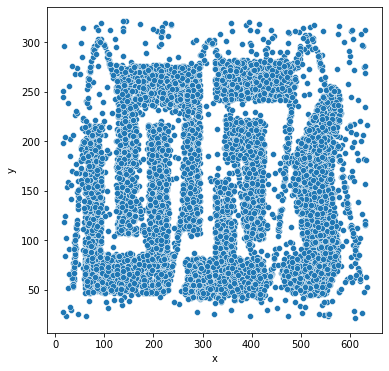

In [270]:
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x = 'x',y = 'y',data = df)
# отчетливо видны отдельные кластеры
# конечное задание - определить оптимальный алгоритм для этого набора данных

In [271]:
# нармализуем

F:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


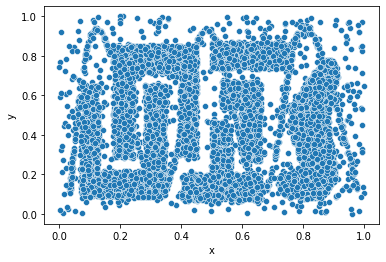

In [272]:
df_mmscaled = MinMaxScaler().fit(df).transform(df)
df_mmscaled = pd.DataFrame(df_mmscaled,columns=['x','y'])
sns.scatterplot('x','y',data = df_mmscaled)

F:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


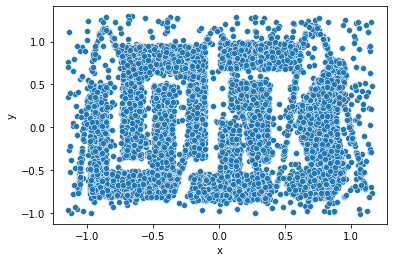

In [273]:
df_rscaled = RobustScaler().fit(df).transform(df)
df_rscaled = pd.DataFrame(df_rscaled,columns=['x','y'])
sns.scatterplot('x','y',data = df_rscaled)

F:\Anaconda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


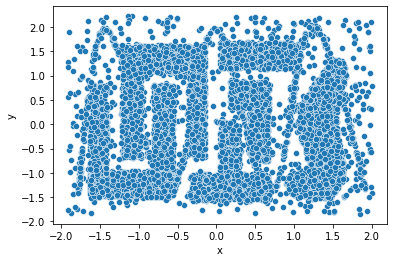

In [274]:
df_sscaled = StandardScaler().fit(df).transform(df)
df_sscaled = pd.DataFrame(df_sscaled,columns=['x','y'])
sns.scatterplot('x','y',data = df_sscaled)

In [275]:
# как видно нормализация в данном наборе не сильно полезна, лишь меняет масштаб,
# некоторые алгоритмы чувствительны к масштабированию, например SVM(support vector machine)
# поэтому нормализацию в данном случае можно не делать если не использовать подобные алгоритмы, 
# но пусть все же будет...StandardScaler (средняя 0, дисперсия 1)

# очеваидно, что на графике есть кластеры (6) и шум в виде отдельных точек и синусоиды
# построим дендограмму 

F:\Anaconda\lib\site-packages\seaborn\matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


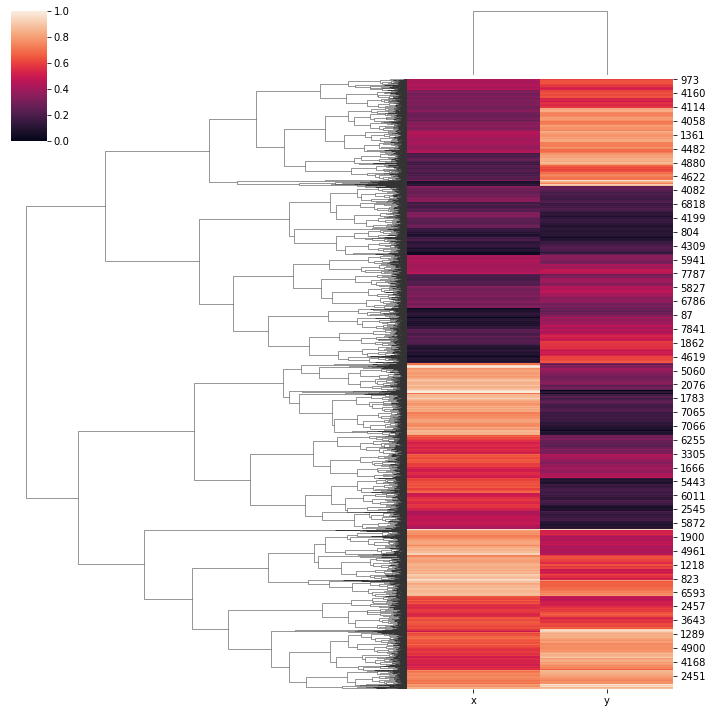

In [276]:
# 9 кластеров для MinMaxScaler
minmax = sns.clustermap(df_mmscaled,dendrogram_ratio=(.6, .1))

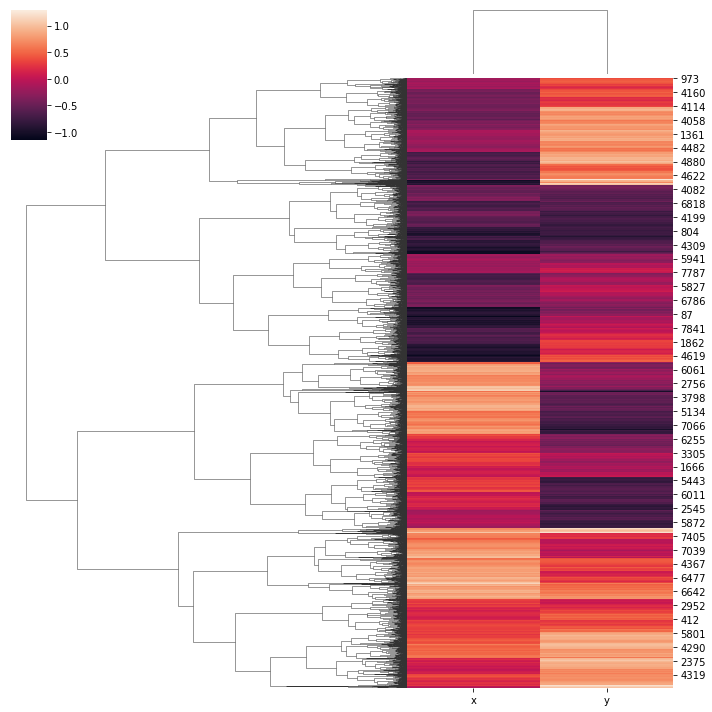

In [277]:
# 9 кластеров для RobustScaler
cluster = sns.clustermap(df_rscaled,dendrogram_ratio=(.6, .1))

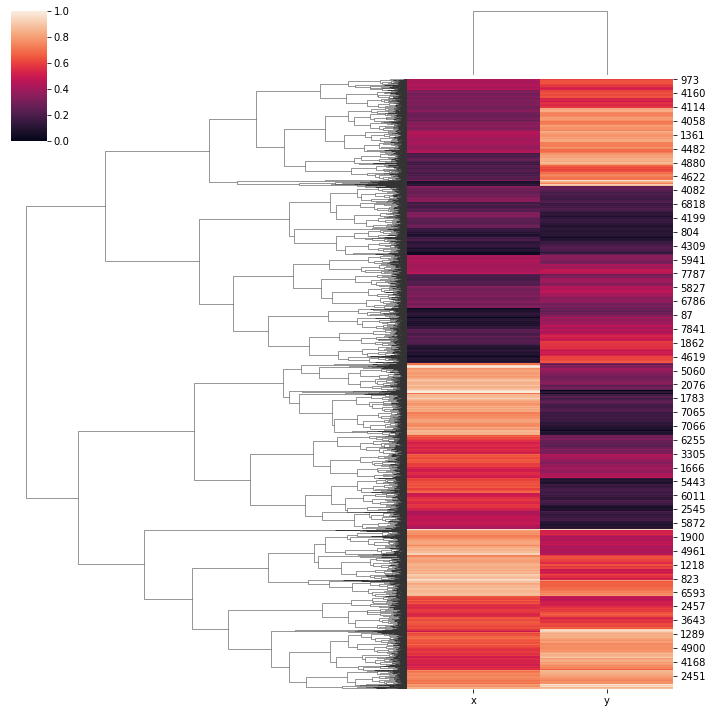

In [278]:
standatd = sns.clustermap(df_sscaled,standard_scale=1,dendrogram_ratio=(.6, .1))
# 9 кластеров для StandatdScaler

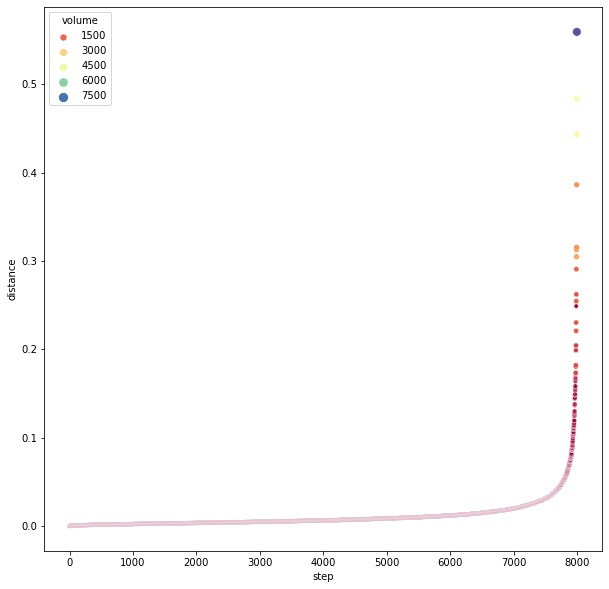

In [205]:
# 8-9 кластеров (смотря как посмотрать на точки с дистанцией 0,29, 0.32)
plot_links(minmax.dendrogram_row.calculated_linkage)

In [207]:
# Алгоритмы : k-mean, Agglomerative clustering (ward/average/complete), DBSCAN
# Нормализация : MinMaxScaler()
df_test = df_mmscaled.copy()


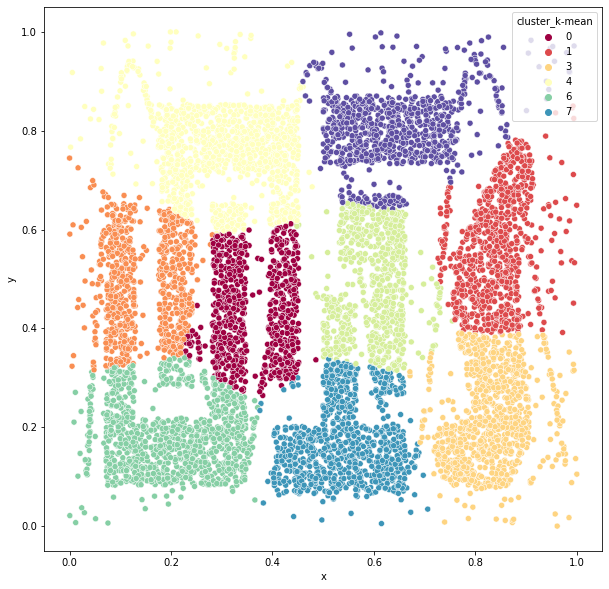

In [247]:
# k-mean 
from sklearn.cluster import KMeans
model = KMeans(n_clusters=9,random_state=101).fit_predict(df_test)
df_mmscaled['cluster_k-mean'] = model
plot_model(df_mmscaled,'cluster_k-mean')
# видно, что k-mean кластеризировал точки на 6 груп, но очевидно не правильно.
# Основная проблема в том что данный алгоритм плохо работает с данными, которые
# выражены сложными формами, как в данном случае.
# Алгоритм подразумевает наличие центроидов, то есть ближайшие точки к
# центроиду получат тот же класс, что и центроид (инициализируется случайно).
# Можно сказать, что кластеры имеют одинаковый диаметр, но граница между
# кластерами проходит точно посередине между центрами кластеров. Поэтому
# учитывать только растояние от центра кластера для данного набора не разумно.


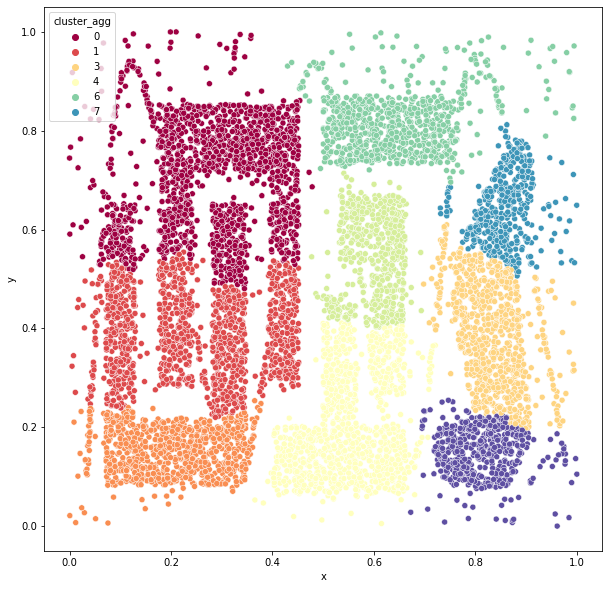

In [292]:
# Agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters=9,linkage='ward').fit_predict(df_test)
df_mmscaled['cluster_agg'] = model
plot_model(df_mmscaled,'cluster_agg')
# Ситуация не сильно улучшилась, если вообще улучшилась. Алгоритм на 1 шаге
# присваевает каждой точке свой кластер, а затем объединяет наиболее похожие кластеры.
# Пока небудет достигнут критерий остановки в виде нужного кол-ва кластеров.
# Схожесть кластеров оцениваеься на основе нескольких критериев связи:
#     ward(default) - объединяет так, чтобы прирост дисперсии был минимальным
#     average - объединяет 2 кластера, которые имеют наименьшее среднее значение всех расстояний между точками кластеров
#     complete - бъединяет 2 кластера,которые имеют наименьшее расстояние между двумя их самыми удаленными точками

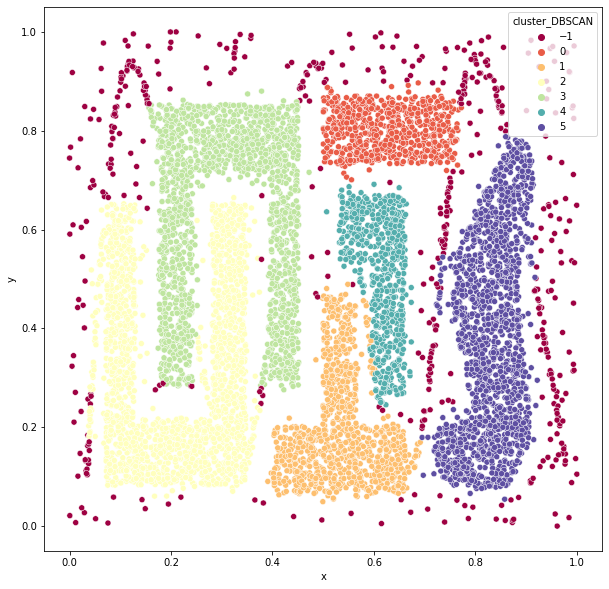

In [393]:
# DBSCAN 0.355 49
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.0356,min_samples=49).fit_predict(df_test)
df_mmscaled['cluster_DBSCAN'] = model
plot_model(df_mmscaled,'cluster_DBSCAN')